# News spreading on youtube from US Channels


## Table of Contents
* [1 Preprocessing and data filtering](#filter_data)
    * [1.1 Filter for Category 'News & Politics'](#filter_data-category)
    * [1.2 Filter for Active Channels](#filter_data-active)
    * [1.3 Get country of channel](#filter_data-country)
    * [1.4 Get if channel is english-speaking](#filter_data-english)
    * [1.5 Filter for language and country and save final data](#filter_data-save)
        * [1.5.1 Filtering relevant comments](#filter_data-comments)
* [2 How US News report on different events](#status_quo)
    * [2.1 Get relevant videos per event](#status_quo-videos_per_event)
    * [2.2 Extract video and channel features](#status_quo-features)
    * [2.3 Results and Comparison between Events](#status_quo-results)
* [3 How does the public response to events](#public_response)
    * [3.1 Compute Public Response Metrics](#public_response-metrics)
    * [3.2 Compute Correlation between Video Features and Response Metrics](#public_response-correlation)
    * [3.3 Compute F- and T-tests](#public_response-ttest)
* [4 Conclusion](#conclusion)

**Global imports**

In [808]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from src.scripts import filters
from datetime import datetime
import matplotlib.dates as mdates
import importlib
from datetime import date

from src.utils import keywords
importlib.reload(keywords)
# from src.utils import analysis_tools

<module 'src.utils.keywords' from 'c:\\Users\\jadbh\\Documents\\Swisse\\EPFL\\courses\\Fall 2024\\ADA\\my project folder 2\\src\\utils\\keywords.py'>

**Path definitions**

In [2]:
path_df_channels_en = 'data/df_channels_en.tsv'
# TODO: not used yet path_df_channels_filtered = 'data/filtered_df_channels_en.csv'

path_df_timeseries = 'data/df_timeseries_en.tsv'

path_yt_metadata_feather = 'data/yt_metadata_helper.feather'
path_yt_metadata_feather_filtered = 'data/filtered_yt_metadata_helper.feather.csv'

path_yt_metadata = 'data/yt_metadata_en.jsonl'
path_yt_metadata_filtered = 'data/filtered_yt_metadata.csv'

path_final_channels = 'data/final_channels.csv'
path_final_timeseries = 'data/final_timeseries.csv'
path_final_yt_metadata_feather = 'data/final_yt_metadata_helper.csv'
path_final_yt_metadata = 'data/final_yt_metadata.csv'

## 2 How US News report on different events <a class="anchor" id="status_quo"></a>

### 2.1 Get relevant videos per event <a class="anchor" id="status_quo-videos_per_event"></a>

TODO: USING JADS CODE AND PLOTS

In [3]:
# load data in such a way to avoid errors
metadata = pl.read_csv(path_final_yt_metadata,  schema_overrides={
                                "dislike_count": pl.Float64,
                                "like_count": pl.Float64},
                                ignore_errors = True)

In [4]:
# counting erroneous like/dislike and date entries
keywords.summarize_outliers(metadata)

Total number of videos: 2,548,064
Date Outlier Count: 164,271
Like/Dislike Outlier Count (null elements): 223,686


In [5]:
# removing rows there the like or dislike entry is null, or where the date entry is erroneous (like "17")
metadata = keywords.filtering_bad_rows(metadata)

Original metadata shape: (2,548,064, 12)
New metadata shape: (2,324,376, 12)


In [6]:
keywords.summarize_outliers(metadata)

Total number of videos: 2,324,376
Date Outlier Count: 0
Like/Dislike Outlier Count (null elements): 0


In [7]:
## removing the hour time from the upload_date since it's always 00:00:00
metadata = keywords.remove_hour(metadata)

In [8]:
list(metadata['title'].sample(20))

['Health care costs should be part of trade talks: Mt. Sinai CEO',
 'First Sikh attorney general has message for Trump, minorities',
 'A Mound With A View',
 "Huawei's chairman describes company as being in 'life or death crisis'",
 'Bonita Springs traffic study suggests overhaul of busy intersection',
 'Making Money At The Festival',
 'OU Football: OU athletic director, Big 12 administrator Donnie Duncan dies at 75',
 '2 Works For You Forecast',
 'Melina Turner, John Battle soccer player, will play at Ferrum',
 'Nevada school board OKs CCSD overhaul',
 "White House Makes 'Inexcusable Move' In Barring CNN Reporter Kaitlan Collins | Morning Joe | MSNBC",
 "Brian's Forecast",
 'Boulder Considers Penalizing Owners Who Build Big Houses',
 "MBTA GM Addresses Rider Concerns, Calls Some Conditions 'Appalling'",
 "Wendy's Twitter account is full of frosty comebacks",
 'Woman recovering after she was shot inside Williamsburg hotel',
 'Blinded by the Light leads a wide variety of films this week

In [120]:
metadata

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
str,str,str,str,f64,str,i64,f64,str,str,date,str
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:23.560250""","""There has been a lot of emotio…",0.0,"""BFlU3b68aNs""",60,3.0,"""politics,news""","""Online reaction swift after Ge…",2019-03-29,"""401 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:25.961967""","""The measure outlaws abortions …",2.0,"""rbBK6syU-fY""",259,31.0,"""politics,news""","""Georgia House passes 'heartbea…",2019-03-29,"""916 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:28.406280""","""The bear has been spotted by s…",0.0,"""u5pwbK0_E0c""",769,7.0,"""animals,local,news,life""","""'Buckhead Bear' spotted rummag…",2019-03-29,"""116 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:30.764228""","""The former X-Factor contestant…",1.0,"""qUPXnZseiTc""",167,34.0,"""the-a-scene,entertainment,tele…","""Behind the sound: Simone Torre…",2019-03-29,"""2521 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:24.684348""","""A yummy springtime spread with…",0.0,"""1JvFjfzlbE8""",359,1.0,"""atlanta-and-company,entertainm…","""Springtime Spread with Lara Ly…",2019-03-29,"""41 """
…,…,…,…,…,…,…,…,…,…,…,…
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:41.255325""","""A new documentary film explore…",0.0,"""XU-phrdiMYQ""",199,0.0,"""WCCO Mid-Morning,reynold phili…","""New Documentary Focused On Min…",2017-06-22,"""1054 """
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:41.963190""","""This Saturday, there's a big e…",0.0,"""cK19B-6ukFs""",189,0.0,"""WCCO Mid-Morning,heartbeat 500…","""Race for Children's: HeartBeat…",2017-06-22,"""21 """
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:42.668689""","""A group of men in Europe are p…",0.0,"""CNrH1AA6wpo""",63,2.0,"""WCCO Mid-Morning,skirts,protes…","""Viewers Weigh In On Men Protes…",2017-06-22,"""74 """


Event: Hurricane Harvey (2017)
Related videos found: 3,602
------------
Event: California Wildfires (2018)
Related videos found: 8,154
------------
Event: Hurricane Maria (2017)
Related videos found: 1,373
------------
Event: Hurricane Michael (2018)
Related videos found: 1,349
------------
Event: Sulawesi Earthquake and Tsunami (2018)
Related videos found: 316
------------
Event: Nepal Earthquake (2015)
Related videos found: 276
------------
Event: Bangladesh Cyclone Mora (2017)
Related videos found: 10
------------
Event: India Floods (2018)
Related videos found: 37
------------
Event: Europe Heatwaves (2019)
Related videos found: 116
------------
Event: Portugal Wildfires (2017)
Related videos found: 52
------------
Event: European Floods (2014)
Related videos found: 102
------------
Event: Greek Wildfires (2018)
Related videos found: 178
------------
Event: Italy Earthquakes (2016)
Related videos found: 265
------------
Event: Hurricane Harvey (2017)
Related videos found: 920
-----

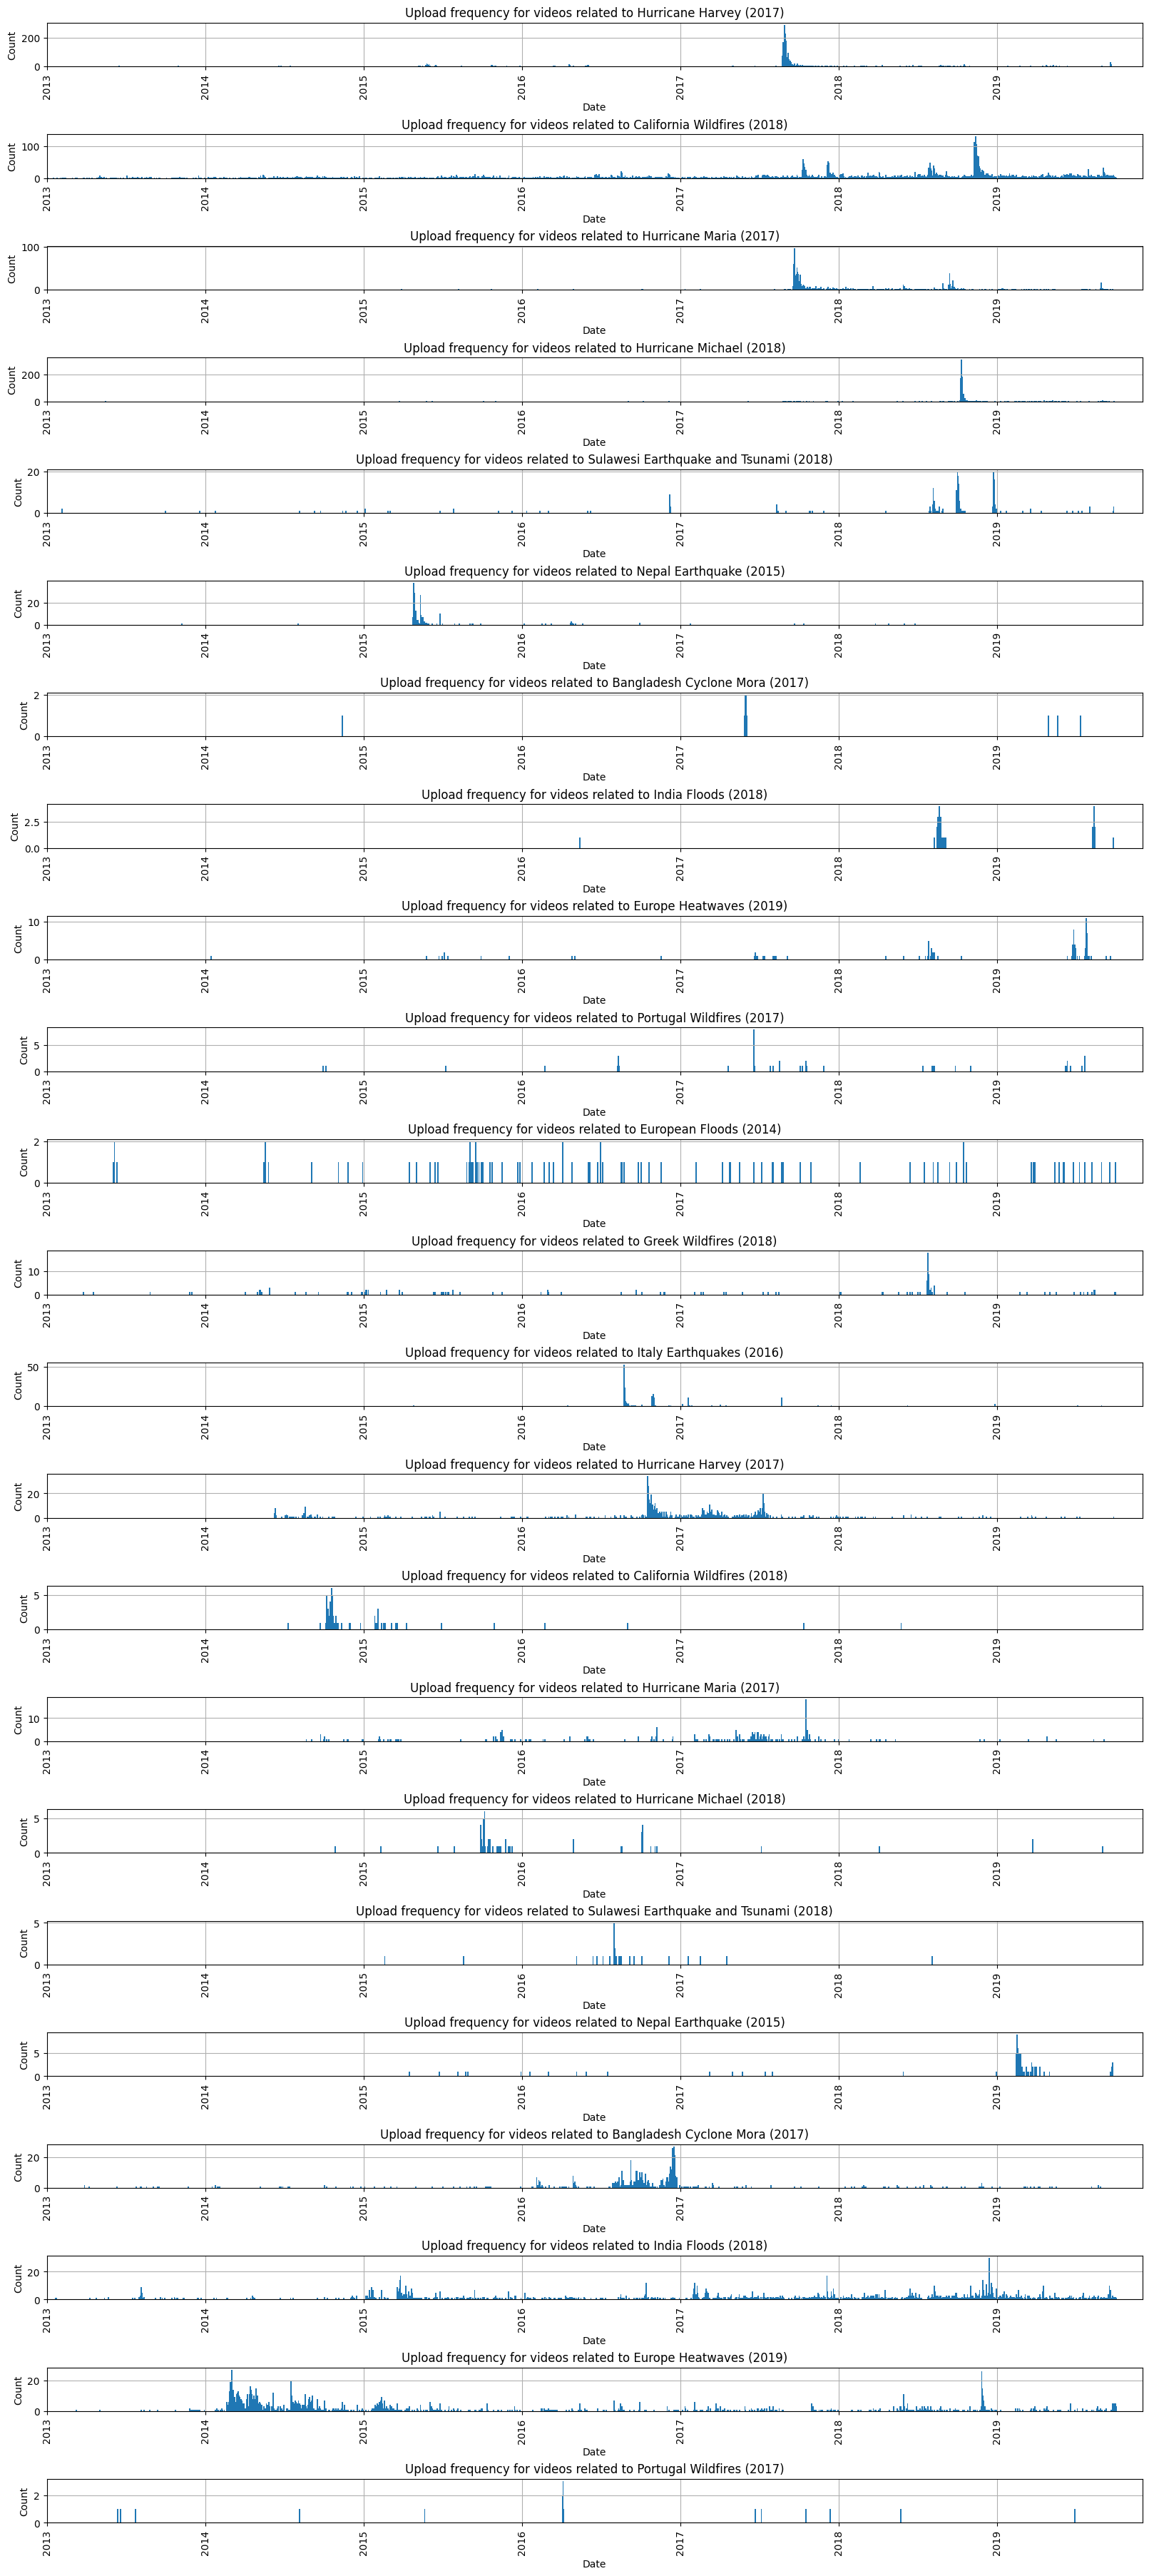

In [961]:
# plot the evolution of upload frequency for each event
importlib.reload(keywords)

"""
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

 """
index = 0   # 0-N List is found in keywords.py

crop_time = False

metadata_2 = metadata.clone()

# metadata_2 = metadata.filter(
#     ~((metadata["channel_id"] == "UCKQECjul8nw1KW_JzfBTP1A")
#         | (metadata["channel_id"] == "UC_YFbvKedjnVjqrZqBR4L8Q")
#         | (metadata["channel_id"] == "UCN3me_2IdGN5C0QV5PubDlQ") 
#         | (metadata["channel_id"] == "UCupvZG-5ko_eiXAupbDfxWw") 
#        )
# )

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCKQECjul8nw1KW_JzfBTP1A")) # & (metadata_2["upload_date"] < date(2018, 4, 9)))
)

metadata_2 = metadata_2.filter(
   ~ ((metadata_2["channel_id"] == "UC_YFbvKedjnVjqrZqBR4L8Q")) #  & (metadata_2["upload_date"] < date(2018, 4, 9)))
)

metadata_2 = metadata_2.filter(                                                 # to remove completely
   ~ (metadata_2["channel_id"] == "UCN3me_2IdGN5C0QV5PubDlQ")
)

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCupvZG-5ko_eiXAupbDfxWw") & (metadata_2["upload_date"] < date(2016, 7, 22)))
)

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCXIJgqnII2ZOINSWNOGFThA"))
)

output = keywords.plot_update_freq_v5(index, metadata_2, all_plots = True, grouping_mode = "daily", crop_time = crop_time, generate = True)     # function that can take individual terms (with or) and groups of terms (with and)

In [963]:
type(output)

polars.dataframe.frame.DataFrame

In [964]:
output.write_csv("flagged_filtered_dataset.csv")

In [967]:
df = pl.read_csv("flagged_filtered_dataset.csv")
df

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,event,region,event_type
str,str,str,str,f64,str,i64,f64,str,str,str,str,str,str,str
"""News & Politics""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:06:47.704585""","""Get up to Speed with Up Late o…",0.0,"""Xgta9SxHnrs""",57,0.0,"""local,news,nation-world,uplate""","""Substitute fired, chief's son …","""2019-09-19""","""112 ""","""Hurricane Harvey (2017)""","""US""","""environmental"""
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:15:02.552547""","""Rising waters are being blamed…",0.0,"""HRmGr3w0EMI""",15,1.0,"""news,nation-world""","""Historic flooding in Texas""","""2018-10-17""","""349 ""","""Hurricane Harvey (2017)""","""US""","""environmental"""
"""News & Politics""","""UCruQg25yVBppUWjza8AlyZA""","""2019-10-30 19:40:05.553989""","""FOX 4 News is a FOX-owned stat…",0.0,"""M8O2WLG0hrY""",173,19.0,"""FOX,KDFW,Dallas,Fort,Worth,Goo…","""Fort Worth buying out flood pr…","""2019-06-20""","""1037 ""","""Hurricane Harvey (2017)""","""US""","""environmental"""
"""News & Politics""","""UCruQg25yVBppUWjza8AlyZA""","""2019-10-30 19:40:34.906505""","""FOX 4 News is a FOX-owned stat…",2.0,"""d3h7-2j6Rz8""",111,27.0,"""FOX,KDFW,Dallas,Fort,Worth,Goo…","""City of Dallas rejects ALL cla…","""2019-06-14""","""2340 ""","""Hurricane Harvey (2017)""","""US""","""environmental"""
"""News & Politics""","""UCruQg25yVBppUWjza8AlyZA""","""2019-10-30 19:40:20.973576""","""FOX 4 News is a FOX-owned stat…",0.0,"""Wg8zqO7mwfk""",105,14.0,"""FOX,KDFW,Dallas,Fort,Worth,Goo…","""Widespread flooding continues …","""2019-05-10""","""847 ""","""Hurricane Harvey (2017)""","""US""","""environmental"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Film & Animation""","""UCBU0SoyQRFlxZdxoOiHPTYw""","""2019-11-19 19:06:54.544534""","""European leaders met in Riga, …",0.0,"""4ABApM_iJPU""",60,1.0,null,"""EU leaders agree $2bn loan to …","""2015-05-22""","""19 ""","""Portugal Wildfires (2017)""","""Europe""","""geopolitical conflict"""
"""News & Politics""","""UC5O114-PQNYkurlTg6hekZw""","""2019-11-12 16:41:08.708735""","""Daily Press Briefing: Myanmar,…",0.0,"""wtrGZ8h7qzs""",1562,14.0,"""UN,United Nations,Myanmar,Bang…","""Jeffrey Feltman's visit to Mya…","""2017-10-17""","""348 ""","""Portugal Wildfires (2017)""","""Europe""","""geopolitical conflict"""
"""News & Politics""","""UC5O114-PQNYkurlTg6hekZw""","""2019-11-12 16:41:49.439378""","""Daily Briefing: Cyprus, Trip A…",0.0,"""3ouepeqBn0Q""",842,4.0,"""UN,United Nations,Cyprus,Defen…","""Defense Conference at UNHQ & o…","""2017-07-06""","""184 ""","""Portugal Wildfires (2017)""","""Europe""","""geopolitical conflict"""


In [935]:
data = output.group_by(by = 'event').count().sort(by = 'count')
list(data["count"])

C:\Users\jadbh\AppData\Local\Temp\ipykernel_23700\485798209.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  data = output.group_by(by = 'event').count().sort(by = 'count')


[10, 37, 52, 102, 116, 178, 265, 276, 316, 1349, 1373, 3602, 8154]

C:\Users\jadbh\AppData\Local\Temp\ipykernel_23700\3761535471.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  data = something.group_by(by = 'channel_id').count().sort(by = 'count')


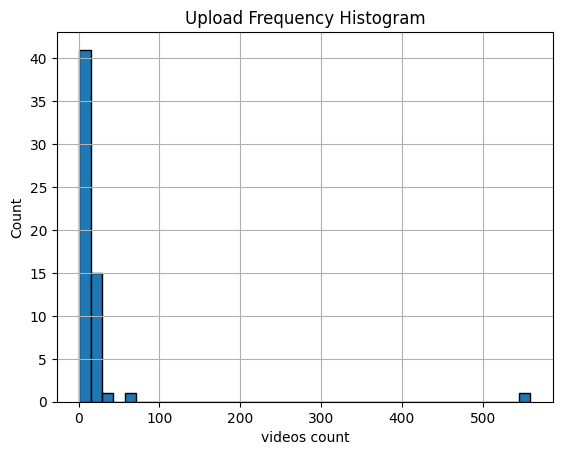

In [ ]:
data = output.group_by(by = 'channel_id').count().sort(by = 'count')

plt.hist(data["count"], bins=40, edgecolor='black')
plt.title("Upload Frequency Histogram")
plt.xlabel("videos count")
plt.grid()
plt.ylabel("Count")
plt.show()